In [2]:
from ellipse_rcnn.pl import EllipseRCNNModule
from ellipse_rcnn.data.prasand import PrasadEllipseDataset
from ellipse_rcnn.data.dataset2 import Data_2_EllipseDataset
from ellipse_rcnn.data.occ24 import occ24EllipseDataset
from ellipse_rcnn.data.industry import IndustryEllipseDataset
from ellipse_rcnn.utils.viz import plot_ellipses, plot_bboxes
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from ellipse_rcnn.core.types import ImageTargetTuple, TargetDict
import torch
import math
from PIL import Image as pil

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\View1_Industrial.bmp, index: 64
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_View1_ind.txt, index: 64


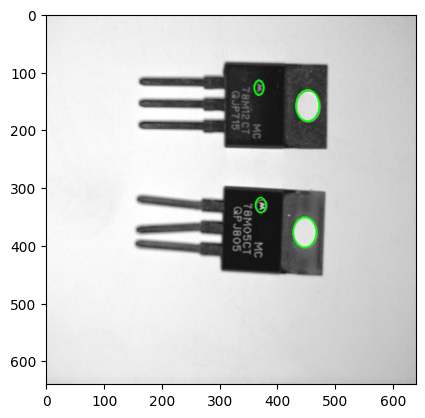

In [ ]:
def display_ellipse(image, ellipse_params):
    for params in ellipse_params:
        # Extracting parameters
        
        axis_length_1 = int(params[0])   # X coordinate of center
        axis_length_2 = int(params[1])   # Y coordinate of center
        center_x = int(params[2])    # Semi-major axis length (half-length)
        center_y = int(params[3])    # Semi-minor axis length (half-length)
        angle = float(params[4]) #* (180 / np.pi)   
        cv2.ellipse(
        image,
        (center_x, center_y),  # Center
        (axis_length_1, axis_length_2),  # Axes lengths should be half-lengths
        angle,
        0,
        360,
        (0, 255, 0),  # Color
        2)                # Thickness (-1 means filled)

    plt.imshow(image)
    plt.show()
image_dir = r'D:\Exercises\HIWI\EllipDet-master\Industrial\images'
annotations_dir = r'D:\Exercises\HIWI\EllipDet-master\Industrial\gt'
model_path = r"D:\Exercises\HIWI\ellipse-rcnn-main\checkpoints\loss=val\loss_total=0.59763-e=epoch=07.ckpt"
image_files = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.endswith(".jpg") or f.endswith(".bmp")  # Include both .jpg and .bmp files
        ])
annotation_files = sorted([
        os.path.join(annotations_dir, f)
        for f in os.listdir(annotations_dir)
        if f.endswith(".txt")
    ])
ds = PrasadEllipseDataset(
                image_files,
                annotation_files,
            )
idx = 64
image,target = ds[idx]
image = image.permute(1,2,0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ellipse_params = target["ellipse_params"]
display_ellipse(image, ellipse_params)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


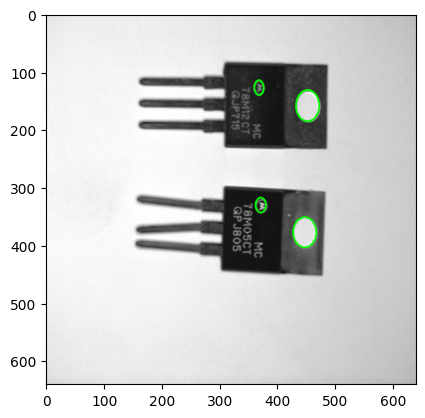

In [41]:
# model = EllipseRCNNModule.load_from_checkpoint(model_path)

# model.eval().cpu()
# with torch.no_grad():
#     pred = model(image.unsqueeze(0))
# score_mask = pred[0]["scores"] > 0.6
# if not len(pred[0]["boxes"][score_mask]) > 0:
#     print(f"No predictions detected for sampled image {idx + 1}.")
# fig, ax = plt.subplots(figsize=(10, 10)) 

# ax.set_aspect("equal")
# ax.axis("off")
# image = image.permute(1, 2, 0) if image.ndim == 3 else image
# ax.imshow(image, cmap="grey")

# ellipses = pred[0]["ellipse_params"][score_mask].view(-1, 5)
# boxes = pred[0]["boxes"][score_mask].view(-1, 4)
# print(f'ellipses: {ellipses}')
# print(f"target: {target['ellipse_params']}")
# # if image.dtype != np.uint8:
#     image = (image * 255).astype(np.uint8) 
ellipse_params = target["ellipse_params"]

for params in ellipse_params:
    # Extracting parameters
    
    axis_length_1 = int(params[0])   # X coordinate of center
    axis_length_2 = int(params[1])   # Y coordinate of center
    center_x = int(params[2])    # Semi-major axis length (half-length)
    center_y = int(params[3])    # Semi-minor axis length (half-length)
    angle = float(params[4]) * (180 / np.pi)   # Convert radians to degrees if necessary
    # print("Image shape:", image.shape)      # Should show H x W x C
    # print("Center:", (center_x, center_y))
    # print("Axes lengths:", (axis_length_1, axis_length_2))
    # print("Angle:", angle)
    
    cv2.ellipse(
    image,
    (center_x, center_y),  # Center
    (axis_length_1, axis_length_2),  # Axes lengths should be half-lengths
    angle,
    0,
    360,
    (0, 255, 0),  # Color
    2)                # Thickness (-1 means filled)

# # Plot ellipses
# plot_ellipses(
#     ellipses,
#     ax=ax,
#     plot_centers=False, # Whehter to plot ellipse centers
#     rim_color="b",
#     alpha=1,
# )
# plot_ellipses(
#             target["ellipse_params"],
#             ax=ax,
#             plot_centers=False,
#             rim_color="r",
#             alpha=1,
#         )
plt.imshow(image)
plt.show()

In [42]:
# from torchvision import transforms
# image = pil.open(image_files[idx])
# image = image.convert("RGB")
# transform = transforms.ToTensor()

# # Convert the image to a tensor
# image_tensor = transform(image)

In [43]:
# print(image_files[idx])
for idx in range(len(annotation_files)):
    # Get the last part of the file path for annotation files
    annotation_file_name = os.path.basename(annotation_files[idx])
    # Get the last part of the file path for image files (if it exists)
    image_file_name = os.path.basename(image_files[idx]) if idx < len(image_files) else "N/A"
    # Print them side by side
    print(f"{annotation_file_name} \t {image_file_name}")
    print("______________________________")


gt_1-1.txt 	 1-1_Industrial.bmp
______________________________
gt_1-2.txt 	 1-2_Industrial.bmp
______________________________
gt_1.txt 	 1_Industrial.bmp
______________________________
gt_2-1a.txt 	 2-1a_Industrial.bmp
______________________________
gt_2-1b.txt 	 2-1b_Industrial.bmp
______________________________
gt_2-2a.txt 	 2-2a_Industrial.bmp
______________________________
gt_2-2b.txt 	 2-2b_Industrial.bmp
______________________________
gt_2.txt 	 2_Industrial.bmp
______________________________
gt_3-1.txt 	 3-1_Industrial.bmp
______________________________
gt_3-2.txt 	 3-2_Industrial.bmp
______________________________
gt_4-1a.txt 	 4-1a_Industrial.bmp
______________________________
gt_4-1b.txt 	 4-1b_Industrial.bmp
______________________________
gt_4-2a.txt 	 4-2a_Industrial.bmp
______________________________
gt_4-2b.txt 	 4-2b_Industrial.bmp
______________________________
gt_4.txt 	 4_Industrial.bmp
______________________________
gt_CST_10.txt 	 CST_10_Industrial.bmp
_____________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\1-1_Industrial.bmp, index: 0
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_1-1.txt, index: 0


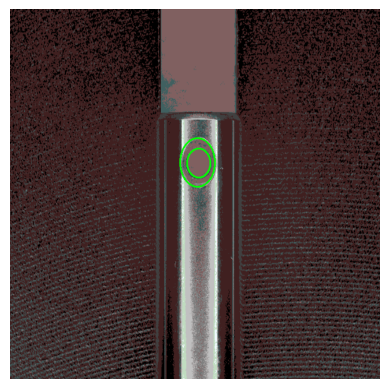

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\1-2_Industrial.bmp, index: 1
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_1-2.txt, index: 1


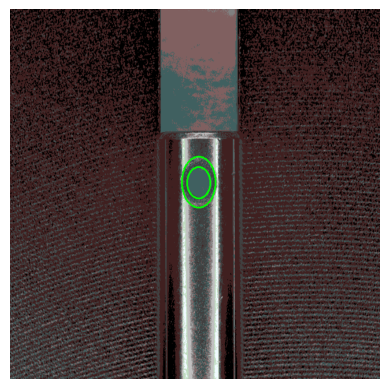

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\1_Industrial.bmp, index: 2
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_1.txt, index: 2


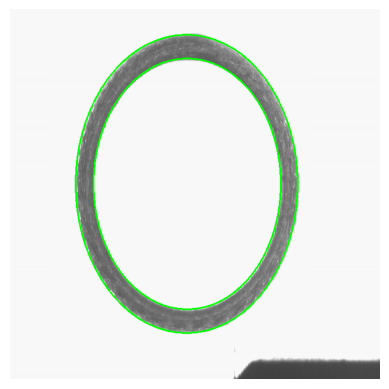

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\2-1a_Industrial.bmp, index: 3
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_2-1a.txt, index: 3


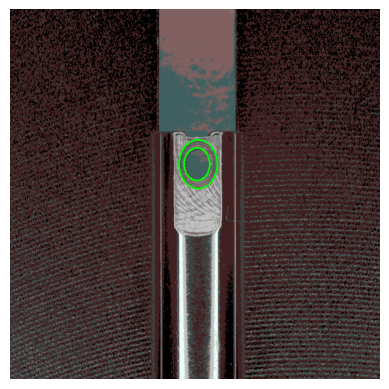

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\2-1b_Industrial.bmp, index: 4
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_2-1b.txt, index: 4


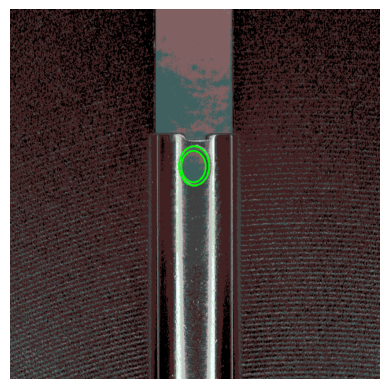

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\2-2a_Industrial.bmp, index: 5
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_2-2a.txt, index: 5


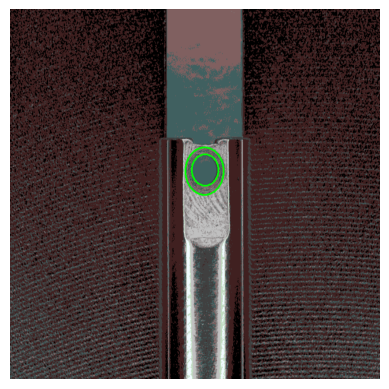

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\2-2b_Industrial.bmp, index: 6
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_2-2b.txt, index: 6


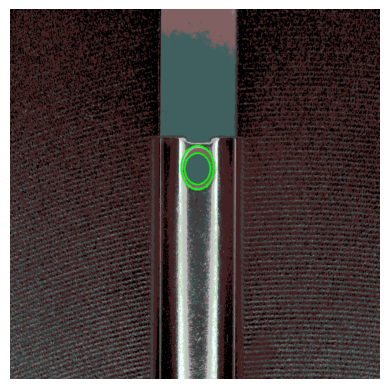

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\2_Industrial.bmp, index: 7
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_2.txt, index: 7


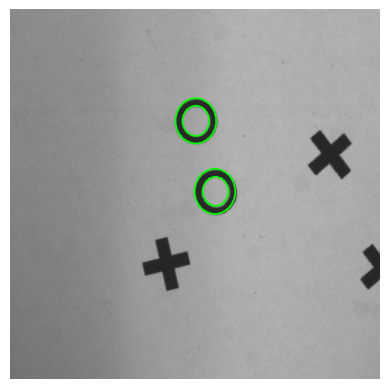

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\3-1_Industrial.bmp, index: 8
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_3-1.txt, index: 8


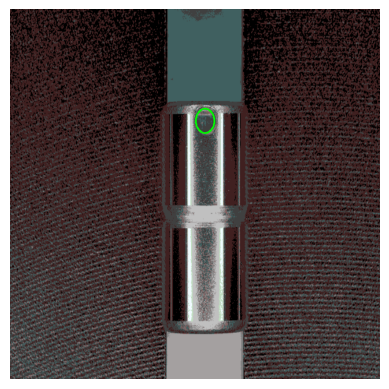

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\3-2_Industrial.bmp, index: 9
annotation_path: D:\Exercises\HIWI\EllipDet-master\Industrial\gt\gt_3-2.txt, index: 9


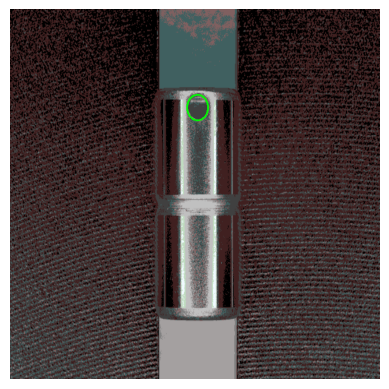

In [ ]:
def display_ellipse(image, ellipse_params):
    for params in ellipse_params:
        # Extracting parameters
        axis_length_1 = int(params[0])   # Semi-major axis length (half-length)
        axis_length_2 = int(params[1])   # Semi-minor axis length (half-length)
        center_x = int(params[2])         # X coordinate of center
        center_y = int(params[3])         # Y coordinate of center
        angle = float(params[4])          # Angle of rotation
        cv2.ellipse(
            image,
            (center_x, center_y),  # Center
            (axis_length_1, axis_length_2),  # Axes lengths
            angle,
            0,
            360,
            (0, 255, 0),  # Color (Green)
            2              # Thickness (-1 means filled)
        )
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()
# Directories for images and annotations
image_dir = r'D:\Exercises\HIWI\EllipDet-master\Industrial\images'
annotations_dir = r'D:\Exercises\HIWI\EllipDet-master\Industrial\gt'
# List of image and annotation files
image_files = sorted([
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.endswith(".jpg") or f.endswith(".bmp")
])
annotation_files = sorted([
    os.path.join(annotations_dir, f)
    for f in os.listdir(annotations_dir)
    if f.endswith(".txt")
])
# Assuming PrasadEllipseDataset is defined elsewhere and works correctly
ds = PrasadEllipseDataset(image_files, annotation_files)
# Loop through the dataset to display each image with ellipses
for idx in range(len(ds)):
    image, target = ds[idx]
    image = image.permute(1, 2, 0).numpy()  # Convert from tensor to numpy array
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    ellipse_params = target["ellipse_params"]
    display_ellipse(image, ellipse_params)
    # Wait for user input to proceed to the next image
    input("Press Enter to continue to the next image...")
